In [1]:
from core.lib.s3 import S3Object
from src.projects.zen_rl.operators.metrics.metrics_builder_op import MetricsBuilderOp

from projects.general.components.cleaning.net_v1 import run as cleaning_run
from projects.zen2_imitation_rolling_autorl.operators.simulation.simulator_op import SimulatorOp
from projects.zen_rl.operators.transform_index.transform_index_op import (
    TransformIndexOp,)
from projects.general.operators.signal_limiter.signal_limiter_op import (
    SignalLimiterOp,
)

import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
def process_net_1sec(net_1sec, lookahead_window=30, signal_interval_offset=10):
    net_1sec = cleaning_run(net_1sec.tz_convert("America/New_York", copy=False))
    signal_limiter_op = SignalLimiterOp(
        **{
            "day_start": "18:40:00",
            "day_end": "16:09:59",
            "weekday_start": "sunday",
            "weekday_end": "friday",
            "drop_dates_between": [
                ("2020-12-24 18:40:00", "2020-12-26 16:09:59"),
                ("2020-12-31 18:40:00", "2021-01-02 16:09:59"),
            ],
        }
    )
    transform_index_op = TransformIndexOp(
        **{
            "signal_interval": f"{lookahead_window}T",
            "signal_interval_offset": signal_interval_offset,
            "day_start": "18:40:00",
            "day_end": "16:09:59",
        }
    )
    net_1sec = signal_limiter_op.transform(X=net_1sec, copy=False)
    net_1sec = transform_index_op.transform(
        X=net_1sec, data_type="net"
    )

    return net_1sec

def simulate(
    net_1sec,
    cost,
    min_cover_amount,
    parsed_action_callback_fn
):
    historical_inputs = pd.DataFrame([], index=net_1sec.index)
    historical_inputs.loc[:, 'parsed_action'] = [(0, )] * len(net_1sec)

    result = SimulatorOp(
        simulator_module='simulator_pureprop', 
        simulator_params={
            "cost": cost,
            "min_cover_amount": min_cover_amount,
            "with_pure_metrics": False,
        }
    ).transform(
        net=net_1sec,
        historical_inputs=historical_inputs,
        parsed_action_callback_fn=parsed_action_callback_fn,
    )
    
    return result

In [3]:
import pandas as pd

# Read the parquet file

currency = 'USDJPY'
# net_1sec = S3Object(f"zen_rl/source/2020-01-01_2024-07-15_{currency}_net_1sec_tzny.parquet.zstd").load(base_dir='/tmp')#.loc['2024-01-01':'2024-06-30']
# net_1sec = S3Object(f"zen_rl/source/2020-01-01_2024-07-28_{currency}_net_1sec_tzny.parquet.zstd").load(base_dir='/tmp').loc['2024-07-01':]
net_1sec = S3Object(f"zen_rl/source/2020-01-01_2024-07-28_{currency}_net_1sec_tzny.parquet.zstd").load(base_dir='/tmp').loc['2023-01-01':'2024-06-30']

In [4]:
net_1sec = process_net_1sec(net_1sec=net_1sec, lookahead_window=30, signal_interval_offset=10)

08:22:01.148 | WARNING | projects.general.operators.signal_limiter.signal_limiter_op - [!] extend_drop_dates given as: True

In [5]:
# different strategies

def uniform_liquidation_prop_callback(parsed_action, res, simulator):
    """
    Implements uniform liquidation strategy as a callback function for the prop simulator
    
    Args:
        x: Current parsed action (not used in this implementation)
        res: Current state dictionary from simulator
        
    Returns:
        tuple: (net_cover,) representing the trading amount
    """
    if res is None:
        # Initial state - no trading
        return (0,)
    
    # Get current position and time info
    current_position = res['net_after_cover']
    minutes_remaining = 43 - res.get('minidx', 0)  # Assuming 43 minute sessions
    
    if minutes_remaining <= 0:
        # At end of session, liquidate entire position
        return (-current_position,)
        
    # If no position, no need to trade
    if current_position == 0:
        return (0,)
        
    # Calculate liquidation rate (spread remaining position over remaining time)
    liquidation_rate = current_position / float(max(minutes_remaining, 1))
    
    # Return negative liquidation rate as net_cover
    # (negative because we want to reduce the position)
    return (-liquidation_rate,)


class FlowQualityPropCallback:
    def __init__(self, session_length=43):
        self.flow_quality_count = 0
        self.last_price = None
        self.session_length = session_length
        
    def __call__(self, parsed_action, res, simulator):
        """
        Implements flow quality adjusted prop trading strategy
        
        Args:
            x: Current parsed action (not used)
            res: Current state dictionary from simulator
            
        Returns:
            tuple: (net_cover,) representing the trading amount
        """
        if res is None:
            return (0,)
            
        # Compute current spot price from bid/ask
        current_bid = res.get('bid')
        current_ask = res.get('ask')
        current_price = (current_ask + current_bid) / 2
        
        # Get current position and time information
        current_position = res['net_after_cover']
        session_remaining = self.session_length - res.get('minidx', 0)
        
        # If no position, no need to trade
        if current_position == 0:
            self.last_price = current_price
            return (0,)
            
        # Calculate base liquidation rate (uniform liquidation)
        liquidation_rate = current_position / float(max(session_remaining, 1))
        
        # Update flow quality count if we have last price
        if self.last_price is not None:
            # Compute price direction
            fx_direction = np.sign(current_price - self.last_price)
            # Get flow direction from current position change
            flow_direction = np.sign(res.get('net_cover', 0))  # net_cover is the coverage amount from the last step
            # Update flow quality count
            self.flow_quality_count += fx_direction * flow_direction
        
        # Adjust liquidation rate based on flow quality
        if current_position > 0:  # Long position
            if self.flow_quality_count > 0:
                # Good flow quality - reduce liquidation rate
                liquidation_rate *= 1 / (np.abs(self.flow_quality_count))
            elif self.flow_quality_count < 0:
                # Bad flow quality - increase liquidation rate
                liquidation_rate *= np.abs(self.flow_quality_count)
                
        elif current_position < 0:  # Short position
            if self.flow_quality_count > 0:
                # Good flow quality - reduce liquidation rate
                liquidation_rate *= 1 / (np.abs(self.flow_quality_count))
            elif self.flow_quality_count < 0:
                # Bad flow quality - increase liquidation rate
                liquidation_rate *= np.abs(self.flow_quality_count)
        
        # Store current price for next iteration
        self.last_price = current_price
        
        # Return negative liquidation rate as net_cover
        # (negative because we want to reduce the position)
        return (-liquidation_rate,)
    

    
##################### quantitle based policy #############################################
class QuantileBasedPropCallback:
    def __init__(self, session_length=43):
        self.price_history = []
        self.session_length = session_length
        
    def __call__(self, parsed_action, res, simulator):
        """
        Implements quantile-based prop trading strategy as a callback function for the simulator
        
        Args:
            x: Current parsed action (not used)
            res: Current state dictionary from simulator
            
        Returns:
            tuple: (net_cover,) representing the trading amount
        """
        if res is None:
            return (0,)
            
        # Compute current spot price from bid/ask
        current_bid = res.get('bid')
        current_ask = res.get('ask')
        current_price = (current_ask + current_bid) / 2
        
        # Update price history
        self.price_history.append(current_price)
        if len(self.price_history) > self.session_length:
            self.price_history.pop(0)
            
        # Get current position and time information
        current_position = res['net_after_cover']
        minutes_remaining = 43 - res.get('minidx', 0)  # Assuming 43 minute sessions
        
        # If no position or no price history, no need to trade
        if current_position == 0 or len(self.price_history) < 2:
            return (0,)
            
        # Calculate base liquidation rate (uniform liquidation)
        liquidation_rate = current_position / float(max(minutes_remaining, 1))
        
        # Calculate price quantiles from history
        upper_quantile = np.quantile(self.price_history, 0.75)
        lower_quantile = np.quantile(self.price_history, 0.25)
        
        # Adjust liquidation rate based on price quantiles
        if current_price > upper_quantile and current_position > 0:
            # Accelerate selling when price is high
            liquidation_rate = current_position * 0.8
        elif current_price < lower_quantile and current_position < 0:
            # Accelerate buying when price is low
            liquidation_rate = current_position * 0.8
            
        # Return negative liquidation rate as net_cover
        # (negative because we want to reduce the position)
        return (-liquidation_rate,)
    
    
    
###################### constant hedging ###############################
def immediate_liquidation_prop_callback(parsed_action, res, simulator):
    """
    Implements immediate liquidation strategy as a callback function for the prop simulator
    
    Args:
        x: Current parsed action (not used in this implementation)
        res: Current state dictionary from simulator
        
    Returns:
        tuple: (net_cover,) representing the trading amount
    """
    if res is None:
        # Initial state - no trading
        return (0,)
    
    # Get current position
    current_position = res['net_after_cover']
    
    if current_position > 0:
        # Long position - liquidate entire position immediately
        return (-current_position,)
        
    elif current_position < 0:
        # Short position - liquidate entire position immediately
        return (-current_position,)
        
    else:
        # No position - no trading needed
        return (0,)

    
###################### constant hedging ###############################
def eod_liquidation_prop_callback(parsed_action, res, simulator):
    """
    Implements eod only liquidation strategy as a callback function for the prop simulator
    
    Args:
        x: Current parsed action (not used in this implementation)
        res: Current state dictionary from simulator
        
    Returns:
        tuple: (net_cover,) representing the trading amount
    """
  
    return (0,)
    


###################### attenuated hedging ###############################

def attenuated_selling_callback(parsed_action, res, simulator, lambda_scaler=.8):

    if res is None:
        # Initial state - no trading
        return (0,)
    
    # Get current position and time info
    current_position = res['net_after_cover']
    windows_remaining = 43 - res.get('minidx', 0)  # Assuming 43 minute sessions
        
    # If no position, no need to trade
    if current_position == 0:
        return (0,)
        
    # Calculate liquidation rate (spread remaining position over remaining time)
    # liquidation_rate = current_position / float(max(windows_remaining, 1))
    # Exponentially scaled sell quantity
    # lambda_param
    # sell_quantity = current_position * np.exp(-lambda_param) # * self.total_sold)
    # lambda_param_finishing_at_T = np.log(current_position/windows_remaining)
    lambda_param_finishing_at_T = np.log(np.abs(current_position))/windows_remaining * lambda_scaler
    sell_quantity = current_position * (1 - np.exp(-lambda_param_finishing_at_T))

    
    # Return negative liquidation rate as net_cover
    # (negative because we want to reduce the position)
    return (-sell_quantity,)


###################### attenuated power law hedging ###############################


def attenuated_power_law_selling_callback(parsed_action, res, simulator, alpha=1.0):
    """
    Callback implementing power law attenuation for inventory liquidation.
    
    Parameters:
    - alpha (float): Shape parameter for controlling the decay curve. Alpha > 1 slows the initial 
                     decay, Alpha < 1 speeds it up.
    """
    
    # Initial state - no trading yet
    if res is None:
        return (0,)
    
    # Get current position and time info
    current_position = res['net_after_cover']
    windows_remaining = 43 - res.get('minidx', 0)  # Assuming a 43-step session
    
    # If no position, no need to trade
    if current_position == 0 or windows_remaining <= 0:
        return (0,)
    
    # Calculate remaining position to sell using power law decay
    t = 0
    T = windows_remaining
    
    # Remaining inventory at current step and next step
    S_t = current_position * ((1 - t / T) ** alpha)
    S_t_next = current_position * ((1 - (t + 1) / T) ** alpha)
    
    # Calculate the sell quantity as the difference between S_t and S_t_next
    sell_quantity = max(S_t - S_t_next, 0)  # Ensure non-negative sell quantity
    
    # Return negative sell quantity to reduce position
    return (-sell_quantity,)



  
##################### quantitle based policy #############################################
class AttenuatedPropCallback:
    def __init__(self, lambda_scaler=1.0):
        self.price_history = []
        self.lambda_scaler = lambda_scaler
        
    def __call__(self, parsed_action, res, simulator):

        if res is None:
            # Initial state - no trading
            return (0,)
        
        # Get current position and time info
        current_position = res['net_after_cover']
        windows_remaining = 43 - res.get('minidx', 0)  # Assuming 43 minute sessions
            
        # If no position, no need to trade
        if current_position == 0:
            return (0,)
            
        # Calculate liquidation rate (spread remaining position over remaining time)
        lambda_param_finishing_at_T = self.lambda_scaler
        sell_quantity = current_position * (1 - np.exp(-lambda_param_finishing_at_T))

        
        # Return negative liquidation rate as net_cover
        # (negative because we want to reduce the position)
        return (-sell_quantity,)

    

class AttenuatedInventoryExponentPropCallback:
    def __init__(self, lambda_scaler=1.0):
        self.price_history = []
        self.lambda_scaler = lambda_scaler
        
    def __call__(self, parsed_action, res, simulator):

        if res is None:
            # Initial state - no trading
            return (0,)
        
        # Get current position and time info
        current_position = res['net_after_cover']
        windows_remaining = 43 - res.get('minidx', 0)  # Assuming 43 minute sessions
            
        # If no position, no need to trade
        if current_position == 0:
            return (0,)
            
        # Calculate liquidation rate (spread remaining position over remaining time)
        lambda_param_finishing_at_T = np.log(current_position)/windows_remaining * self.lambda_scaler
        sell_quantity = current_position * (1 - np.exp(-lambda_param_finishing_at_T))

        
        # Return negative liquidation rate as net_cover
        # (negative because we want to reduce the position)
        return (-sell_quantity,)

  
##################### quantitle based policy #############################################
class AttenuatedPowerLawPropCallback:
    def __init__(self, alpha_scaler=1.0):
        self.price_history = []
        self.alpha_scaler = alpha_scaler
        
    def __call__(self, parsed_action, res, simulator):
        """
        Callback implementing power law attenuation for inventory liquidation.
        
        Parameters:
        - alpha (float): Shape parameter for controlling the decay curve. Alpha > 1 slows the initial 
                        decay, Alpha < 1 speeds it up.
        """
        
        # Initial state - no trading yet
        if res is None:
            return (0,)
        
        # Get current position and time info
        current_position = res['net_after_cover']
        windows_remaining = 43 - res.get('minidx', 0)  # Assuming a 43-step session
        
        # If no position, no need to trade
        if current_position == 0 or windows_remaining <= 0:
            return (0,)
        
        # Calculate remaining position to sell using power law decay
        t = 0
        T = windows_remaining
        
        # Remaining inventory at current step and next step
        S_t = current_position * ((1 - t / T) ** self.alpha_scaler)
        S_t_next = current_position * ((1 - (t + 1) / T) ** self.alpha_scaler)
        
        # Calculate the sell quantity as the difference between S_t and S_t_next
        sell_quantity = max(S_t - S_t_next, 0)  # Ensure non-negative sell quantity
        
        # Return negative sell quantity to reduce position
        return (-sell_quantity,)


###################### constant hedging ###############################
def immediate_liquidation_prop_callback(parsed_action, res, simulator):
    """
    Implements immediate liquidation strategy as a callback function for the prop simulator
    
    Args:
        x: Current parsed action (not used in this implementation)
        res: Current state dictionary from simulator
        
    Returns:
        tuple: (net_cover,) representing the trading amount
    """
    if res is None:
        # Initial state - no trading
        return (0,)
    
    # Get current position
    current_position = res['net_after_cover']
    
    if current_position > 0:
        # Long position - liquidate entire position immediately
        return (-current_position,)
        
    elif current_position < 0:
        # Short position - liquidate entire position immediately
        return (-current_position,)
        
    else:
        # No position - no trading needed
        return (0,)


In [ ]:
strategies = {}

strategies['uniform_liquidation'] = uniform_liquidation_prop_callback
strategies['eod_liquidation'] = eod_liquidation_prop_callback

for scaler in [x * 0.005 for x in range(14, 18)]:
    strategies[f'attenuated_liquidation_{scaler}'] = AttenuatedInventoryExponentPropCallback(lambda_scaler=scaler)

benchmark_strategy = "eod_liquidation"

In [7]:
results_map = {}

for name, strat in strategies.items():
    print(name)
    
    if name in results_map.keys():
        print(f'already computed {name}')
        continue
    else:
        results_map[name] = simulate(
            net_1sec=net_1sec,
            cost=0.001,
            min_cover_amount=0,
            parsed_action_callback_fn=strat
        )
    


uniform_liquidation


100%|██████████| 386/386 [01:02<00:00,  6.21it/s]


eod_liquidation


100%|██████████| 386/386 [01:03<00:00,  6.07it/s]


attenuated_liquidation_0.07


  0%|          | 0/386 [00:00<?, ?it/s]/tmp/ipykernel_70029/4216105131.py:341: RuntimeWarning: invalid value encountered in log
  lambda_param_finishing_at_T = np.log(current_position)/windows_remaining * self.lambda_scaler
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: Passing `np.nan` to mean no clipping in np.clip has always been unreliable, and is now deprecated. In future, this will always return nan, like it already does when min or max are arrays that contain nan. To skip a bound, pass either None or an np.inf of an appropriate sign.
  return bound(*args, **kwds)
100%|██████████| 386/386 [01:07<00:00,  5.72it/s]


attenuated_liquidation_0.075


  0%|          | 0/386 [00:00<?, ?it/s]/tmp/ipykernel_70029/4216105131.py:341: RuntimeWarning: invalid value encountered in log
  lambda_param_finishing_at_T = np.log(current_position)/windows_remaining * self.lambda_scaler
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: Passing `np.nan` to mean no clipping in np.clip has always been unreliable, and is now deprecated. In future, this will always return nan, like it already does when min or max are arrays that contain nan. To skip a bound, pass either None or an np.inf of an appropriate sign.
  return bound(*args, **kwds)
100%|██████████| 386/386 [01:05<00:00,  5.92it/s]


attenuated_liquidation_0.08


  0%|          | 0/386 [00:00<?, ?it/s]/tmp/ipykernel_70029/4216105131.py:341: RuntimeWarning: invalid value encountered in log
  lambda_param_finishing_at_T = np.log(current_position)/windows_remaining * self.lambda_scaler
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: Passing `np.nan` to mean no clipping in np.clip has always been unreliable, and is now deprecated. In future, this will always return nan, like it already does when min or max are arrays that contain nan. To skip a bound, pass either None or an np.inf of an appropriate sign.
  return bound(*args, **kwds)
100%|██████████| 386/386 [01:19<00:00,  4.87it/s]


attenuated_liquidation_0.085


  0%|          | 0/386 [00:00<?, ?it/s]/tmp/ipykernel_70029/4216105131.py:341: RuntimeWarning: invalid value encountered in log
  lambda_param_finishing_at_T = np.log(current_position)/windows_remaining * self.lambda_scaler
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: Passing `np.nan` to mean no clipping in np.clip has always been unreliable, and is now deprecated. In future, this will always return nan, like it already does when min or max are arrays that contain nan. To skip a bound, pass either None or an np.inf of an appropriate sign.
  return bound(*args, **kwds)
100%|██████████| 386/386 [01:18<00:00,  4.92it/s]


In [8]:
import joblib
joblib.dump(results_map, 'results_map.pkl')

['results_map.pkl']

In [9]:
dfs = {}
for _key in list(results_map.keys()):

    dfs[_key] = MetricsBuilderOp().transform(inferences=results_map[_key], name=str(_key))['daily'].T

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/app/src/projects/zen_rl/operators/metrics/metrics_builder_op.py:232: RuntimeWarning: invalid value encountered in double_scalars
  cpcr_sharpe = daily_cpcrs.mean() / daily_cpcrs.std()
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=

In [10]:
pd.concat(dfs, axis=1)

uniform_liquidation  \
                                2023-01-02 00:00:00-05:00   
daily_pl                                    -7.082871e+07   
daily_net_cover_pl                           8.261945e+06   
daily_cpcrs                                  1.670584e+00   
daily_cprs                                  -1.432173e+01   
daily_drawdowns                             -1.913627e+08   
daily_coverage_ratios                        6.724810e-03   
daily_long_boundary_hit_ratios                        NaN   
daily_short_boundary_hit_ratios                       NaN   
daily_boundary_hit_ratios                    0.000000e+00   
daily_long_boundary_mean                              NaN   
daily_short_boundary_mean                             NaN   
daily_long_boundary_median                            NaN   
daily_short_boundary_median                           NaN   
daily_long_boundary_std                               NaN   
daily_short_boundary_std                              NaN   
daily_pl__trade                             -2.526988e+06   
daily_cprs__trade                           -5.109628e-01   

                                                           \
                                2023-01-03 00:00:00-05:00   
daily_pl                                     2.996480e+08   
daily_net_cover_pl                          -4.001981e+07   
daily_cpcrs                                 -7.291423e+00   
daily_cprs                                   5.459446e+01   
daily_drawdowns                             -1.529587e+08   
daily_coverage_ratios                        8.797832e-03   
daily_long_boundary_hit_ratios                        NaN   
daily_short_boundary_hit_ratios                       NaN   
daily_boundary_hit_ratios                    0.000000e+00   
daily_long_boundary_mean                              NaN   
daily_short_boundary_mean                             NaN   
daily_long_boundary_median                            NaN   
daily_short_boundary_median                           NaN   
daily_long_boundary_std                               NaN   
daily_short_boundary_std                              NaN   
daily_pl__trade                             -2.464604e+07   
daily_cprs__trade                           -4.490394e+00   

                                                           \
                                2023-01-04 00:00:00-05:00   
daily_pl                                     9.003930e+07   
daily_net_cover_pl                           5.467066e+06   
daily_cpcrs                                  1.069755e+00   
daily_cprs                                   1.761821e+01   
daily_drawdowns                             -3.131825e+08   
daily_coverage_ratios                        1.281396e-02   
daily_long_boundary_hit_ratios                        NaN   
daily_short_boundary_hit_ratios                       NaN   
daily_boundary_hit_ratios                    0.000000e+00   
daily_long_boundary_mean                              NaN   
daily_short_boundary_mean                             NaN   
daily_long_boundary_median                            NaN   
daily_short_boundary_median                           NaN   
daily_long_boundary_std                               NaN   
daily_short_boundary_std                              NaN   
daily_pl__trade                             -8.620865e+07   
daily_cprs__trade                           -1.686866e+01   

                                                           \
                                2023-01-05 00:00:00-05:00   
daily_pl                                     5.508425e+08   
daily_net_cover_pl                          -3.414942e+07   
daily_cpcrs                                 -5.248107e+00   
daily_cprs                                   8.465387e+01   
daily_drawdowns                             -5.797871e+07   
daily_coverage_ratios                        1.268725e-02   
daily_long_boundary_hit_ratios                        NaN   
daily_sho

In [11]:
performance_summary = []
for _key in list(dfs.keys()):
    if 'FlowQuality' in _key:
        continue
    performance_summary.append((_key, dfs[str(_key)].loc['daily_cprs', :].mean(), 
                                dfs[str(_key)].loc['daily_cprs', :].std(),
                                dfs[str(_key)].loc['daily_cprs', :].mean()/dfs[str(_key)].loc['daily_cprs', :].std()))

df = pd.DataFrame(performance_summary)
df.columns = ['strategy', 'mean(daily_cprs)', 'std(daily_cprs)', 'mean(daily_cprs)/std(daily_cprs)']
df

,strategy,mean(daily_cprs),std(daily_cprs),mean(daily_cprs)/std(daily_cprs)
0,uniform_liquidation,9.175281,61.708762,0.148687
1,eod_liquidation,9.403454,99.442403,0.094562
2,attenuated_liquidation_0.07,1172.155996,1724.909298,0.679546
3,attenuated_liquidation_0.075,1190.553989,1692.159689,0.703571
4,attenuated_liquidation_0.08,1187.974965,1730.840874,0.686357
5,attenuated_liquidation_0.085,1221.511480,1781.751088,0.685568


In [12]:
dfs.keys()

dict_keys(['uniform_liquidation', 'eod_liquidation', 'attenuated_liquidation_0.07', 'attenuated_liquidation_0.075', 'attenuated_liquidation_0.08', 'attenuated_liquidation_0.085'])

In [13]:
performance_summary = []
for _key in list(dfs.keys()):
    if 'FlowQuality' in _key or benchmark_strategy in _key:
        continue
    print(_key)
    performance_summary.append((_key, dfs[str(_key)].loc['daily_cprs__trade', :].mean(), 
                                dfs[str(_key)].loc['daily_cprs__trade', :].std(),
                                dfs[str(_key)].loc['daily_cprs__trade', :].mean()/dfs[str(_key)].loc['daily_pl__trade', :].std()))

df = pd.DataFrame(performance_summary)
df.columns = ['strategy', 'mean(daily_cprs__trade)', 'std(daily_cprs__trade)', 'mean(daily_cprs__trade)/std(daily_cprs__trade)']
df

uniform_liquidation
attenuated_liquidation_0.07
attenuated_liquidation_0.075
attenuated_liquidation_0.08
attenuated_liquidation_0.085


,strategy,mean(daily_cprs__trade),std(daily_cprs__trade),mean(daily_cprs__trade)/std(daily_cprs__trade)
0,uniform_liquidation,-1.065442,48.076332,-5.000892e-09
1,attenuated_liquidation_0.07,-0.037976,30.132165,-2.793066e-10
2,attenuated_liquidation_0.075,0.104244,31.167463,7.389736e-10
3,attenuated_liquidation_0.08,0.192750,32.664510,1.298197e-09
4,attenuated_liquidation_0.085,0.011213,33.099251,7.402712e-11


# Revised plots with sharpe study

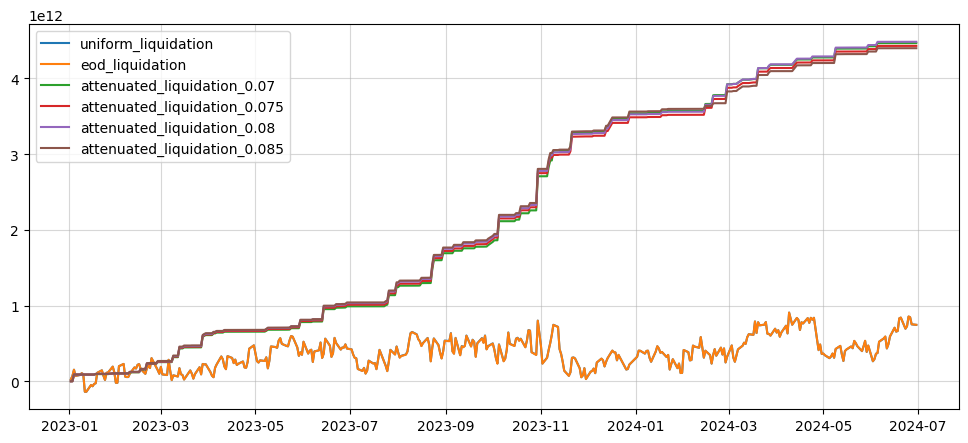

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5)) 
for _key in list(results_map.keys()):
    
    plt.plot(results_map[_key]['cash_after_cover__trade'].groupby(level=0).last().cumsum(), label=_key)

plt.grid(alpha=0.5)
plt.legend(loc='upper left')
plt.show()

In [16]:
# check that all end of day mtm value of the inventory are zero
assert (results_map[_key]['net_value_after_cover'].groupby(level=0).last() == 0).all()

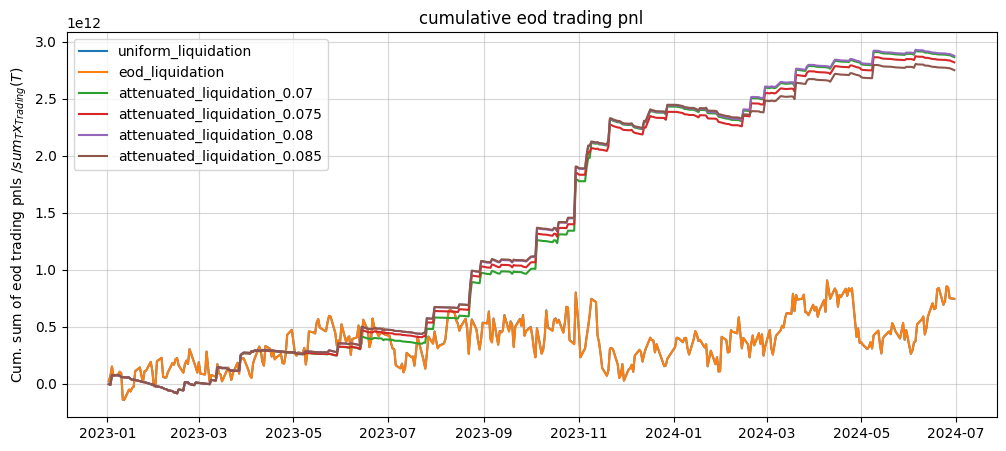

In [17]:
# over time we see that there are differences but in a lower magnitude
fig, ax = plt.subplots(figsize=(12, 5)) 
for _key in list(results_map.keys()):
    
    # get the trading pnl of the contender strategy
    contender = (results_map[_key]['net_value_after_cover'] + results_map[_key]['cash_after_cover__trade']).groupby(level=0).last().cumsum()
    
    plt.plot(contender, label=_key)

plt.grid(alpha=0.5)
plt.legend(loc='upper left')
plt.title('cumulative eod trading pnl')
plt.ylabel('Cum. sum of eod trading pnls $/sum_T x_{Trading}(T)$')
plt.show()


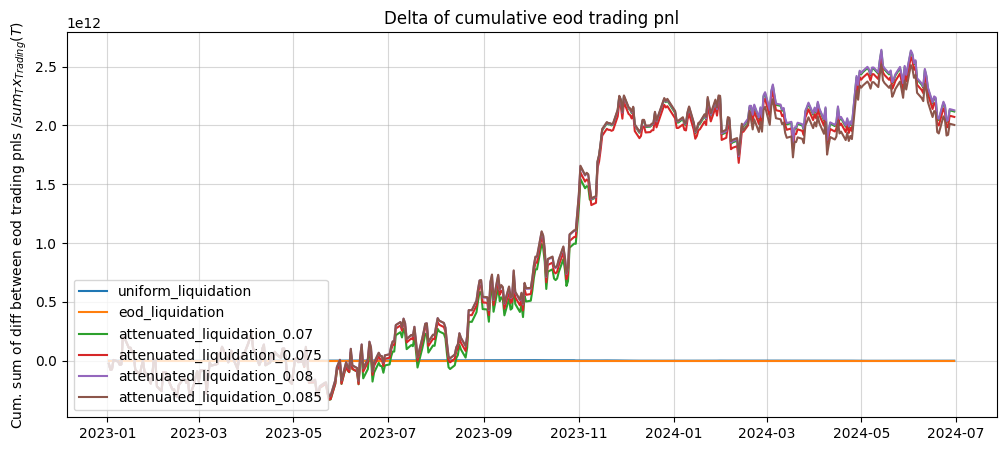

In [18]:
# hence let's look at the delta between the different policies
# note it is irrelevant if you include market making cash or not
# so you can replace the below 'cash_after_cover__trade' with 'cash_after_cover'

fig, ax = plt.subplots(figsize=(12, 5)) 
for _key in list(results_map.keys()):
    
    # get the trading pnl of the contender strategy
    contender = (results_map[_key]['net_value_after_cover'] + results_map[_key]['cash_after_cover__trade']).groupby(level=0).last().cumsum()
    
    # and the benchmark (can be the eod liquidation)
    bm = (results_map[benchmark_strategy]['net_value_after_cover'] + results_map[benchmark_strategy]['cash_after_cover__trade']).groupby(level=0).last().cumsum()
    plt.plot(contender-bm, label=_key)

plt.grid(alpha=0.5)
plt.legend(loc='lower left')
plt.title('Delta of cumulative eod trading pnl')
plt.ylabel('Cum. sum of diff between eod trading pnls $/sum_T x_{Trading}(T)$')
plt.show()

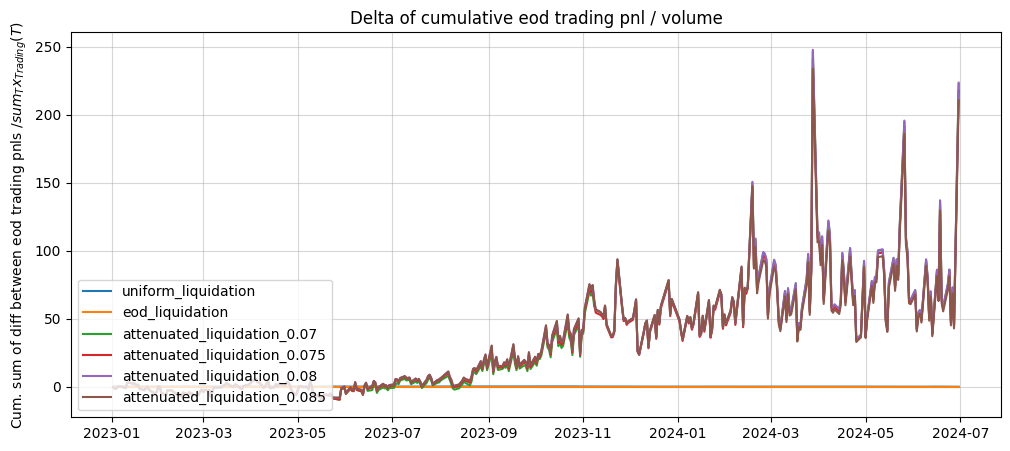

In [19]:
# same as above but divided by daily volume

fig, ax = plt.subplots(figsize=(12, 5)) 
for _key in list(results_map.keys()):
    
    # get the trading pnl of the contender strategy
    contender = (results_map[_key]['net_value_after_cover'] + results_map[_key]['cash_after_cover__trade']).groupby(level=0).last().cumsum()
    volume = results_map[_key]['total'].groupby(level=0).sum()
    contender = contender /volume
    # and the benchmark (can be the eod liquidation)
    bm = (results_map[benchmark_strategy]['net_value_after_cover'] + results_map[benchmark_strategy]['cash_after_cover__trade']).groupby(level=0).last().cumsum()
    bm = bm/volume
    plt.plot(contender-bm, label=_key)

plt.grid(alpha=0.5)
plt.legend(loc='lower left')
plt.title('Delta of cumulative eod trading pnl / volume')
plt.ylabel('Cum. sum of diff between eod trading pnls $/sum_T x_{Trading}(T)$')
plt.show()

Text(0, 0.5, 'Delta PnL')

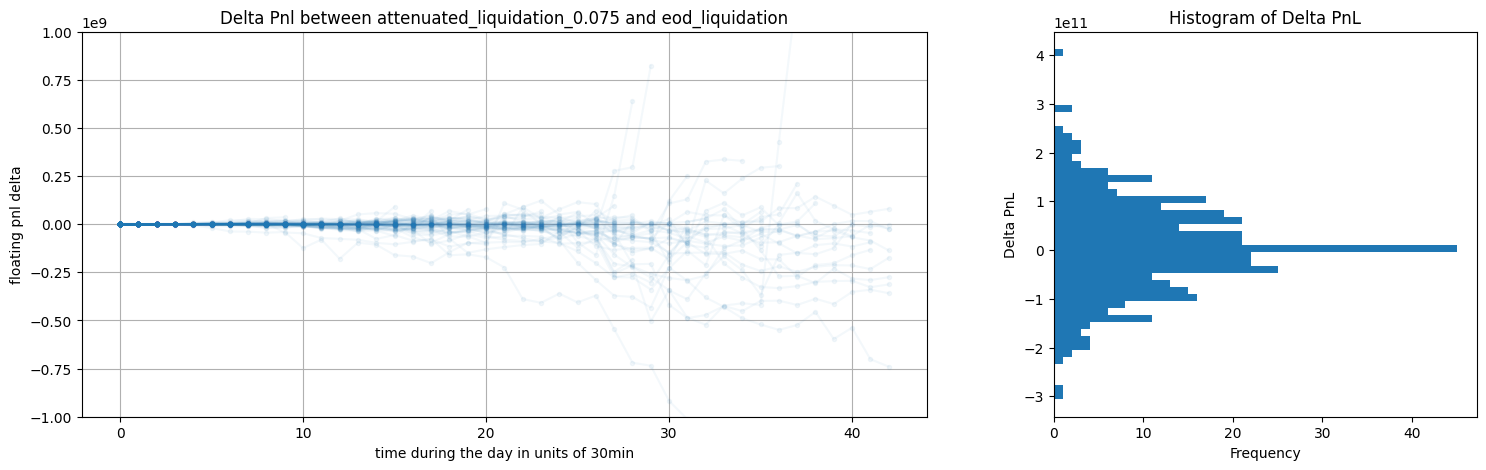

In [20]:
# okay, how about the daily distributions of the deltas

# how does SBI LM buisness look like in absence of inventory control (eod liquidation only)
# overlaying all days.
contender_strategy = 'attenuated_liquidation_0.075'
which_strategy = 'attenuated_liquidation_0.075'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})

################
# all days plot
################
all_days = results_map[which_strategy]['net_value_after_cover'].index.get_level_values(0).unique()

for day in all_days:

    # get performance of benchmark
    bm = results_map[benchmark_strategy]['net_value_after_cover'].loc[day] + results_map[benchmark_strategy]['cash_after_cover'].loc[day]

    # and of contender
    contender = results_map[contender_strategy]['net_value_after_cover'].loc[day] + results_map[contender_strategy]['cash_after_cover'].loc[day]
    
    # plot delta pnl
    ax1.plot(contender.values - bm.values, '.-', color='tab:blue', alpha=0.05)

ax1.set_title(f'Delta Pnl between {contender_strategy} and {benchmark_strategy}')
ax1.grid()
ax1.set_xlabel('time during the day in units of 30min')
ax1.set_ylabel('floating pnl delta')
ax1.set_ylim(-10e8, 10e8)


################
# histrogram
###############
contender = (results_map[contender_strategy]['net_value_after_cover'] + results_map[contender_strategy]['cash_after_cover__trade']).groupby(level=0).last()
bm = (results_map[benchmark_strategy]['net_value_after_cover'] + results_map[benchmark_strategy]['cash_after_cover__trade']).groupby(level=0).last()

ax2.hist(contender-bm, bins=50, orientation='horizontal')
ax2.set_title('Histogram of Delta PnL')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Delta PnL')

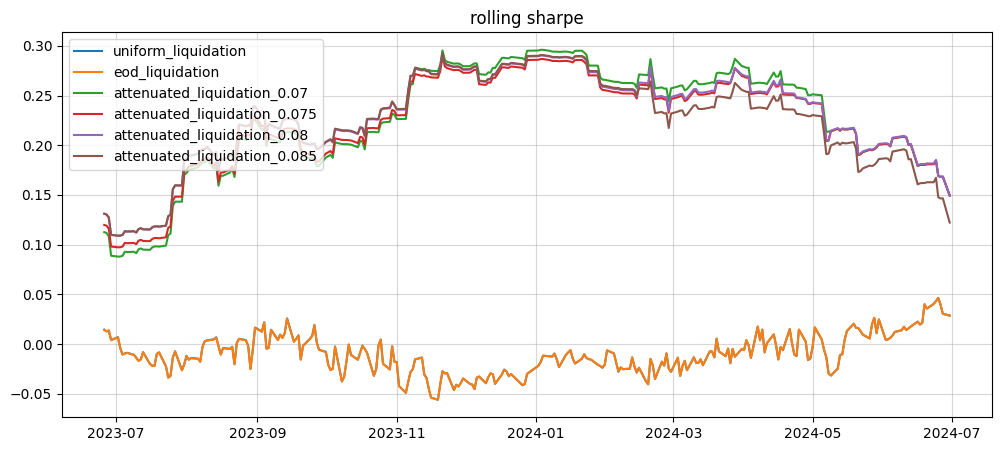

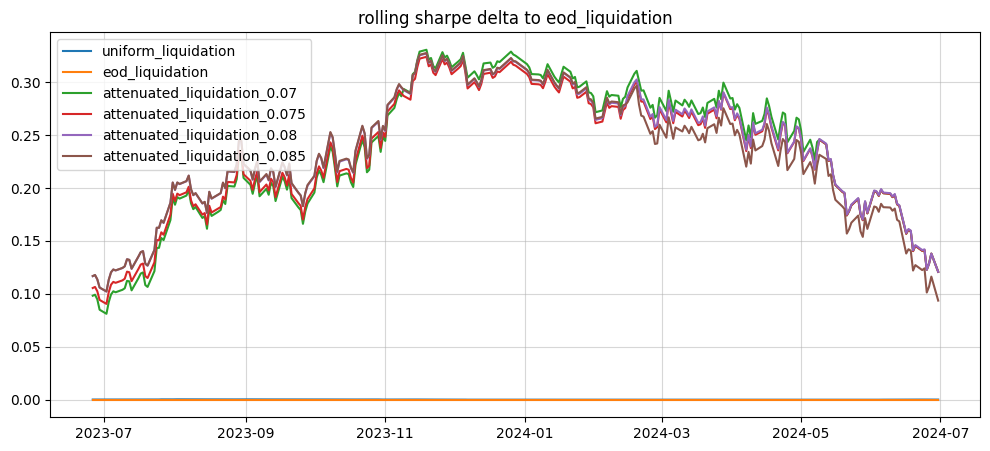

In [21]:
########################################################
# Calculate Something Like Sharpe based on eod Trade Pnl
########################################################

# note the sharpe will be bad, but we will need to find
# relative performers, we can add the shapre of the total Pnl 
# in the next cell


window = 21*6

# trading pnl from the benchmark
bm = (results_map[benchmark_strategy]['net_value_after_cover'] + results_map[benchmark_strategy]['cash_after_cover__trade']).groupby(level=0).last()

# get the daily volume
volume = (results_map[benchmark_strategy]['total']).groupby(level=0).sum()

# scale pnl by inverse volume
bm = bm/volume

# get the sharpe
bm_sharpe = bm.rolling(window).mean() / bm.rolling(window).std()

######################
# Sharpe values
######################

fig, ax = plt.subplots(figsize=(12, 5)) 
for _key in list(results_map.keys()):
    
    contender = (results_map[_key]['net_value_after_cover'] + results_map[_key]['cash_after_cover__trade']).groupby(level=0).last()
    contender = contender/volume
    
    contender_sharpe = contender.rolling(window).mean() / contender.rolling(window).std()
    
    plt.plot(contender_sharpe, label=_key)

plt.grid(alpha=0.5)
plt.legend(loc='upper left')
plt.title('rolling sharpe')
plt.show()




######################
# Sharpe Diff
######################

fig, ax = plt.subplots(figsize=(12, 5)) 
for _key in list(results_map.keys()):
    
    contender = (results_map[_key]['net_value_after_cover'] + results_map[_key]['cash_after_cover__trade']).groupby(level=0).last()
    contender = contender/volume
    
    contender_sharpe = contender.rolling(window).mean() / contender.rolling(window).std()
    
    plt.plot(contender_sharpe - bm_sharpe, label=_key)

plt.grid(alpha=0.5)
plt.legend(loc='upper left')
plt.title(f'rolling sharpe delta to {benchmark_strategy}')
plt.show()

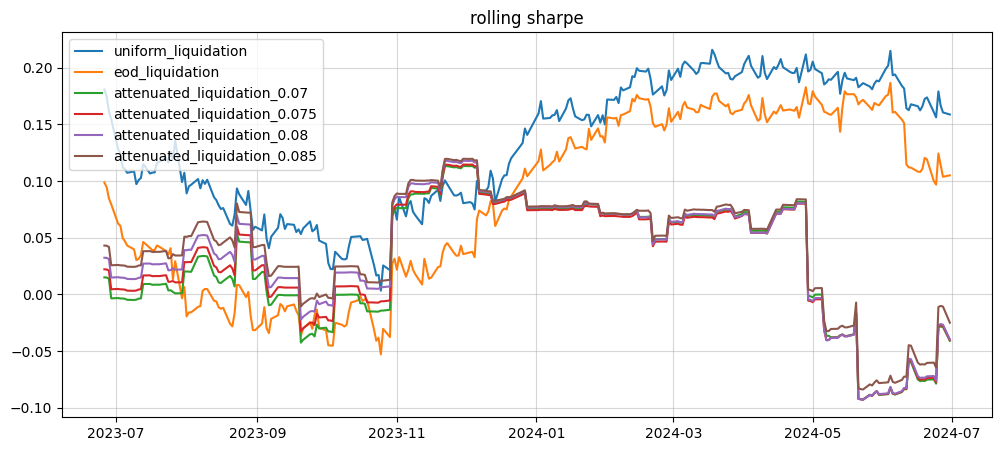

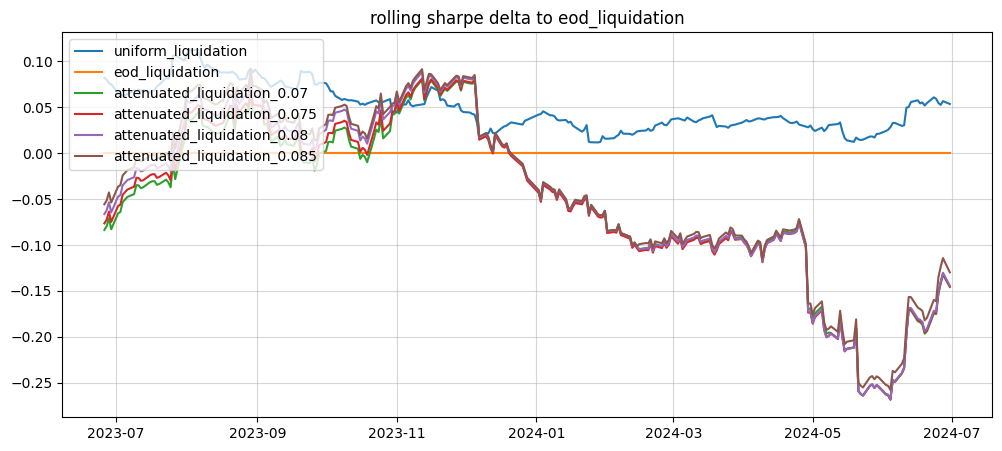

In [22]:
########################################################
# Calculate Something Like Sharpe based on eod Total Pnl 
# (see cash variable change now includes market making)
########################################################

# note the sharpe will be bad, but we will need to find
# relative performers, we can add the shapre of the total Pnl 
# in the next cell


window = 21*6

# trading pnl from the benchmark
bm = (results_map[benchmark_strategy]['net_value_after_cover'] + results_map[benchmark_strategy]['cash_after_cover']).groupby(level=0).last()

# get the daily volume
volume = (results_map[benchmark_strategy]['total']).groupby(level=0).sum()

# scale pnl by inverse volume
bm = bm/volume

# get the sharpe
bm_sharpe = bm.rolling(window).mean() / bm.rolling(window).std()

######################
# Sharpe values
######################

fig, ax = plt.subplots(figsize=(12, 5)) 
for _key in list(results_map.keys()):
    
    contender = (results_map[_key]['net_value_after_cover'] + results_map[_key]['cash_after_cover']).groupby(level=0).last()
    contender = contender/volume
    
    contender_sharpe = contender.rolling(window).mean() / contender.rolling(window).std()
    
    plt.plot(contender_sharpe, label=_key)

plt.grid(alpha=0.5)
plt.legend(loc='upper left')
plt.title('rolling sharpe')
plt.show()




######################
# Sharpe Diff
######################

fig, ax = plt.subplots(figsize=(12, 5)) 
for _key in list(results_map.keys()):
    
    contender = (results_map[_key]['net_value_after_cover'] + results_map[_key]['cash_after_cover']).groupby(level=0).last()
    contender = contender/volume
    
    contender_sharpe = contender.rolling(window).mean() / contender.rolling(window).std()
    
    plt.plot(contender_sharpe - bm_sharpe, label=_key)

plt.grid(alpha=0.5)
plt.legend(loc='upper left')
plt.title(f'rolling sharpe delta to {benchmark_strategy}')
plt.show()
